# GRAD CAM

by SHRIRAM GADDAM

In [1]:
## importing necessary libraries
import keras
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 

from skimage.transform import resize
import cv2

import tensorflow as tf

from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Loading VGG16 for imagenet

In [0]:
## Load VGG16
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
from skimage import io


In [0]:
model = VGG16(weights="imagenet")

In [7]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Part 1

### Defining gradCAM function

In [0]:
def gradCAM(img, model, layer_name, class_id=None):
  img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  
  if class_id:
    class_idx = class_id
  else:
    class_idx = np.argmax(preds[0])

  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_name)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  #print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  #print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  #print(conv_layer_output_value.shape)
  #print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
  from google.colab.patches import cv2_imshow
  
  cv2_imshow(img)
  print()
  print(f"Heatmap from {layer_name}")
  cv2_imshow(superimposed_img)
  
  

## Visualising gradCAM results from 3 different layers

In [0]:
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")

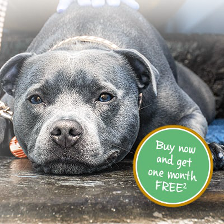


Heatmap from block5_conv3


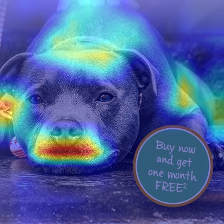

In [12]:
## current layer
gradCAM(dog, model, "block5_conv3")

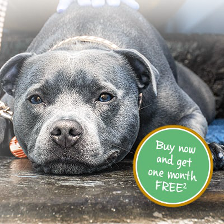


Heatmap from block5_conv2


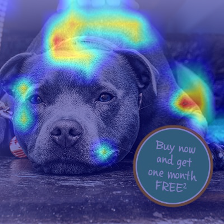

In [13]:
## previous layer
gradCAM(dog, model, "block5_conv2")

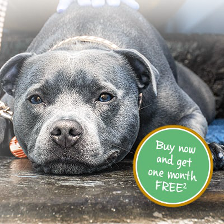


Heatmap from block5_conv1


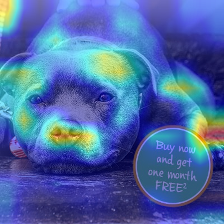

In [14]:
## 2 layers before the current layer 
gradCAM(dog, model, "block5_conv1")

## Finding sunglasses in the image

In [15]:
!wget -O tony.jpg http://www.domain.com/filename-4.0.1.zip https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg

--2020-05-13 02:56:30--  http://www.domain.com/filename-4.0.1.zip
Resolving www.domain.com (www.domain.com)... 13.228.112.135
Connecting to www.domain.com (www.domain.com)|13.228.112.135|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.domain.com/filename-4.0.1.zip [following]
--2020-05-13 02:56:30--  https://www.domain.com/filename-4.0.1.zip
Connecting to www.domain.com (www.domain.com)|13.228.112.135|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.domain.com/filename-4? [following]
URL transformed to HTTPS due to an HSTS policy
--2020-05-13 02:56:31--  https://www.domain.com/filename-4?
Reusing existing connection to www.domain.com:443.
HTTP request sent, awaiting response... 404 Not Found
2020-05-13 02:56:33 ERROR 404: Not Found.

--2020-05-13 02:56:33--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jp

In [0]:
tony = io.imread("/content/tony.jpg")

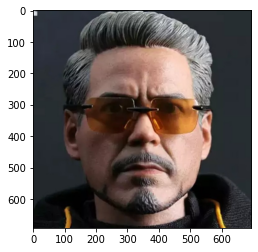

In [17]:
plt.imshow(tony)

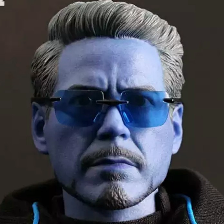


Heatmap from block5_conv3


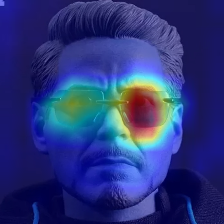

In [18]:
# id for sunglasses
# 836: 'sunglass',
# 837: 'sunglasses, dark glasses, shades'

gradCAM(tony, model, "block5_conv3", class_id=836)

## Finding fly in the image

In [19]:
!wget -O fly.jpg https://image.shutterstock.com/image-photo/fly-on-food-dish-260nw-452914108.jpg

--2020-05-13 02:56:55--  https://image.shutterstock.com/image-photo/fly-on-food-dish-260nw-452914108.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 23.44.1.139
Connecting to image.shutterstock.com (image.shutterstock.com)|23.44.1.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7602 (7.4K) [image/jpeg]
Saving to: ‘fly.jpg’

fly.jpg             100%[===================>]   7.42K  --.-KB/s    in 0.03s   

2020-05-13 02:56:56 (255 KB/s) - ‘fly.jpg’ saved [7602/7602]



In [0]:
fly = io.imread("/content/fly.jpg")

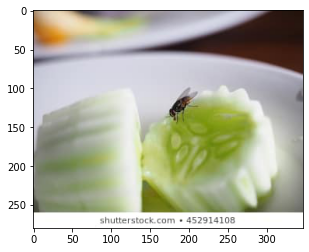

In [21]:
plt.imshow(fly)

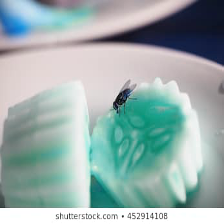


Heatmap from block5_conv3


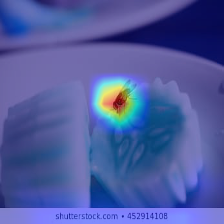

In [22]:
# 308: 'fly',
gradCAM(fly, model, "block5_conv3", class_id=308)

## Finding sunglasses and fly in the same image

In [0]:
## modified the gradCAM function to take multiple class_ids

def gradCAM(img, model, layer_name, **kwargs): 
  print(f"Original image")
  img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  cv2_imshow(img)

  if kwargs:
    for k,v in kwargs.items():
      
      img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)

      class_name  = k
      class_idx = v
      
      class_output = model.output[:, class_idx]
      last_conv_layer = model.get_layer(layer_name)
      grads = K.gradients(class_output, last_conv_layer.output)[0]
      pooled_grads = K.mean(grads, axis=(0, 1, 2))
      iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

      pooled_grads_value, conv_layer_output_value = iterate([x])

      for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

      heatmap = np.mean(conv_layer_output_value, axis = -1)
      heatmap = np.maximum(heatmap, 0)
      heatmap /= np.max(heatmap)

      heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
      heatmap = np.uint8(255 * heatmap)
      heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
      superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
      
      print()
      print(f"{class_name} - {class_idx}")
      cv2_imshow(superimposed_img)

  

In [0]:
tony_fly = io.imread("/content/drive/My Drive/GradCam/tony_fly.png")

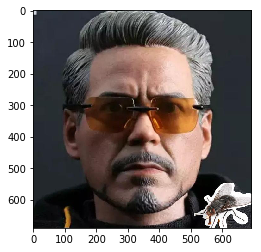

In [0]:
plt.imshow(tony_fly)

Original image


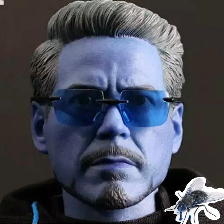


sunglasses - 836


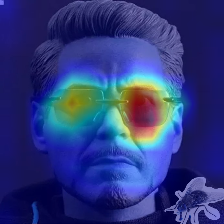


fly - 308


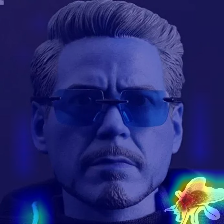

In [0]:
# 308: 'fly',
# 836: 'sunglass',

gradCAM(tony_fly, model, "block5_conv3", sunglasses=836, fly=308)

BELOW IS THE DOCUMENTATION

# Intoduction



We propose a technique for making Convolutional Neural Network (CNN)-based models more transparent by visualizing the regions of input that are "important" for predictions from these models - or visual explanations. Our approach, called Gradient-weighted Class Activation Mapping (Grad-CAM), uses the class-specific gradient information flowing into the final convolutional layer of a CNN to produce a coarse localization map of the important regions in the image. Grad-CAM is a strict generalization of the Class Activation Mapping. Unlike CAM, Grad-CAM requires no re-training and is broadly applicable to any CNN-based architectures. Grad-CAM provides explanations to better understand image classification, image captioning, and visual question answering (VQA) models. In the context of image classification models, our visualizations (a) lend insight into their failure modes showing that seemingly unreasonable predictions have reasonable explanations, and (b) outperform pixel-space gradient visualizations (Guided Backpropagation and Deconvolution) on the ILSVRC-15 weakly supervised localization task. For image captioning and VQA, our visualizations expose the somewhat surprising insight that common CNN + LSTM models can often be good at localizing discriminative input image regions despite not being trained on grounded image-text pairs. Finally, we conduct Experiment studies to measure if Grad-CAM explanations help users establish trust in the predictions made by deep networks. Interestingly, we can visualize that Grad-CAM helps untrained users successfully discern a "stronger" deep network from a "weaker" one even when both networks make identical predictions.

visualize class activation maps for debugging deep neural networks using an algorithm called Grad-CAM. We will then implement Grad-CAM using Keras and TensorFlow.

While deep learning has facilitated unprecedented accuracy in image classification, object detection, and image segmentation, one of their biggest problems is model interpretability, a core component in model understanding and model debugging.

In practice, deep learning models are treated as “black box” methods, and many times we have no reasonable idea as to:

Where the network is “looking” in the input image
Which series of neurons activated in the forward-pass during inference/prediction
How the network arrived at its final output
That raises an interesting question — how can you trust the decisions of a model if you cannot properly validate how it arrived there?

To help deep learning practitioners visually debug their models and properly understand where it’s “looking” in an image, Gradient-weighted Class Activation Mapping, or more simply, Grad-CAM is used:

Grad-CAM uses the gradients of any target concept (say logits for “dog” or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.”

Using Grad-CAM, we can visually validate where our network is looking, verifying that it is indeed looking at the correct patterns in the image and activating around those patterns.

If the network is not activating around the proper patterns/objects in the image, then we know:
Our network has not properly learned the underlying patterns in our dataset
Our training procedure needs to be revisited
We may need to collect additional data
And most importantly, our model is not ready for deployment.
Grad-CAM is a tool that should be in any deep learning practitioner’s toolbox — take the time to learn how to apply it now.
Grad-CAM provides the importance of debugging and visually verifying that your convolutional neural network is “looking” at the right places in an image.
From there, we’ll dive into Grad-CAM, an algorithm that can be used visualize the class activation maps of a Convolutional Neural Network (CNN), thereby allowing you to verify that your network is “looking” and “activating” at the correct locations.

We will then implement Grad-CAM using Keras and TensorFlow.


This method is:
Easily implemented
Works with nearly any Convolutional Neural Network architecture
Can be used to visually debug where a network is looking in an image
Grad-CAM works by (1) finding the final convolutional layer in the network and then (2) examining the gradient information flowing into that layer.

The output of Grad-CAM is a heatmap visualization for a given class label (either the top, predicted label or an arbitrary label we select for debugging). We can use this heatmap to visually verify where in the image the CNN is looking.






# Methods:

This method is: Easily implemented Works with nearly any Convolutional Neural Network architecture Can be used to visually debug where a network is looking in an image Grad-CAM works by (1) finding the final convolutional layer in the network and then (2) examining the gradient information flowing into that layer.

The output of Grad-CAM is a heatmap visualization for a given class label (either the top, predicted label or an arbitrary label we select for debugging). We can use this heatmap to visually verify where in the image the CNN is looking.

STEPS TO COMPLETE:

using keras and tensorflow implenetation and visualsation tools like Keras-vis,matplotlib to show the heat activation maps of the image.
defining a function gradcam.
implementing keras VGG16 network architecture.
Visualising the grad camresults from 3 different layers not just one output layer. 5.Experiments some on different kinds of images.E.g: Finding Sunglasses ,an insect in a image etc.
For this process i'm going to refer to other research paper published and from the online sources.


CONFIGURING THE DEVELOPMENT ENVIRONMENT:

In order to use our Grad-CAM implementation, we need to configure our system with a few software packages including

TensorFlow (2.0 recommended)
OpenCV

OpenCV:
OpenCV (Open Source Computer Vision Library) is a library of programming functions mainly aimed at real-time computer vision

OpenCV's application areas include:

2D and 3D feature toolkits
Facial recognition system
Gesture recognition
OpenCV includes a statistical machine learning library that contains:

Boosting
Decision tree learning
Gradient boosting trees
Expectation-maximization algorithm
k-nearest neighbour algorithm
Naive Bayes classifier
Artificial neural networks
Random forest
Support vector machine (SVM)
OpenCV (Open Source Computer Vision Library) is an open source computer vision and machine learning software library. OpenCV was built to provide a common infrastructure for computer vision applications and to accelerate the use of machine perception in the commercial products. Being a BSD-licensed product, OpenCV makes it easy for businesses to utilize and modify the code.

The library has more than 2500 optimized algorithms, which includes a comprehensive set of both classic and state-of-the-art computer vision and machine learning algorithms. These algorithms can be used to detect and recognize faces, identify objects, classify human actions in videos, track camera movements, track moving objects, extract 3D models of objects, produce 3D point clouds from stereo cameras, stitch images together to produce a high resolution image of an entire scene, find similar images from an image database, remove red eyes from images taken using flash, follow eye movements, recognize scenery and establish markers to overlay it with augmented reality, etc. OpenCV has more than 47 thousand people of user community and estimated number of downloads exceeding 18 million. The library is used extensively in companies, research groups and by governmental bodies.


Before we define the GradCAM class, we need to import several packages. These include a TensorFlow Model for which we will construct our gradient model, NumPy for mathematical calculations, and OpenCV.

A TensorFlow model which we will use to compute a heatmap
The classIdx — a specific class index that we will use to measure our class activation heatmap
An optional CONV layer Name of the model in case we want to visualize the heatmap of a specific layer of our CNN; otherwise, if a specific layer name is not provided, we will automatically infer on the final CONV/POOL layer of the model architecture .
Now that our constructor is defined and our class attributes are set, let us define a method to find our target layer:
Finally, the last step of our compute heatmap method returns the heatmap to the caller.
Given that we have computed our heatmap, now we would like a method to transparently overlay the Grad-CAM heatmap on our input image.

You could also use Grad-CAM as a “weak” form of detection, but it’s not a robust solution and won’t work nearly as well as training a dedicated object detector such as Faster R-CNNs, SSDs, etc.
Keras:

Keras is the high-level API of TensorFlow 2.0: an approachable, highly productive interface for solving machine learning problems, with a focus on modern deep learning. It provides essential abstractions and building blocks for developing and shipping machine learning solutions with high iteration velocity.

VGG16:
VGG16 is a convolutional neural network model.

The input to cov1 layer is of fixed size 224 x 224 RGB image. The image is passed through a stack of convolutional (conv.) layers, where the filters were used with a very small receptive field: 3×3 (which is the smallest size to capture the notion of left/right, up/down, centre). In one of the configurations, it also utilizes 1×1 convolution filter, which is a linear transformation of the input channels (followed by non-linearity). The convolution stride is fixed to 1 pixel; the spatial padding of conv. layer input is such that the spatial resolution is preserved after convolution, i.e. the padding is 1-pixel for 3×3 conv. layers. Spatial pooling is carried out by five max-pooling layers, which follow some of the conv.  layers (not all the conv. layers are followed by max-pooling). Max-pooling is performed over a 2×2-pixel window, with stride 2.

Three Fully-Connected (FC) layers follow a stack of convolutional layers (which has a different depth in different architectures): the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is the soft-max layer. The configuration of the fully connected layers is the same in all networks.

All hidden layers are equipped with the rectification (ReLU) non-linearity. It is also noted that none of the networks (except for one) contain Local Response Normalisation (LRN), such normalization does not improve the performance on the ILSVRC dataset but leads to increased memory consumption and computation time.

The VGG16 architecture consists of twelve convolutional layers, some of which are followed by maximum pooling layers and then four fully connected layers and finally a 1000-way SoftMax classifier.

ImageNet:

Pre-trained weights can be automatically loaded upon instantiation (weights='ImageNet' argument in model constructor for all image models.

ImageNet Is a dataset of over 15 million labelled high-resolution images belonging to roughly 22,000 categories. The images were collected from the web and labelled by human labellers using Amazon’s Mechanical Turk crowd-sourcing tool. Starting in 2010, as part of the Pascal Visual Object Challenge, an annual competition called the ImageNet Large-Scale Visual Recognition Challenge (ILSVRC) has been held. ILSVRC uses a subset of ImageNet with roughly 1000 images in each of 1000 categories. In all, there are roughly 1.2 million training images, 50,000 validation images, and 150,000 testing images. 

Heat map

A heat map (or heatmap) is a data visualization technique that shows magnitude of a phenomenon as colour in two dimensions. The variation in colour may be by hue or intensity, giving obvious visual cues to the reader about how the phenomenon is clustered or varies over space. 

Max Pooling Layer

Pooling layers provide an approach to down sampling feature maps by summarizing the presence of features in patches of the feature map
Maximum pooling, or max pooling, is a pooling operation that calculates the maximum, or largest, value in each patch of each feature map.

The results are down sampled or pooled feature maps that highlight the most present feature in the patch, not the average presence of the feature in the case of average pooling. This has been found to work better in practice than average pooling for computer vision tasks like image classification.



# PROCEDURE and RESULTS: 

The first step we need to import the libraries and packages required. We are going to load the VGG16 pretrained architecture. model. Summary() we will provide you details about the architecture of the network. We are going to load the network with ImageNet dataset. Next, we are going to define the GradCAM function. It is a straightforward algorithm which takes image, model, layer name as the input parameters. Using CV2 library we are going to resize all different sizes image to standard(224,224) size. If the images are of lesser than standard size, then we are going to enlarge them using INTERCUBIC Interpolation.

Using CV libraries, we are generating the heat maps by taking the convolutional layer output. We are going to apply the COLORMAP_JET for discerning the pixels depending on the intensities of it. Finally, we are going to superimpose the original image on the heatmap. Observations: We are going to Visualise the GradCAM results from 3 different layers. On block5_Conv3 it is to identify the sunglasses in the image. From the classes list, class_ID=836 is to identify the sunglasses. So initially we plot the original image with sunglasses. Then after applying GradCAM we can see in the heatmap image how the sunglasses it is focusing on the eyes. In the first experiment we are going to implement on How GradCAM works on the Dog image at various levels. We have taken the output from the three layers i.e., current output layers and previous layers to identify how exactly it is recognizing the object. In the previous layers output to present layer output we can identify how network is recognizing the object. In final layer output It can identify the dog’s mouth, ears and limbs. In the previous layer block5_Conv1 we can see that the network detected the mouth of the dog with less intensity and when it reaches the final layer the intensity of recognizing the mouth increased (Red). In the third experiment to detect an object of the fly. The class id for the fly is 308 in the ImageNet data set. We have three visual plotting, original image, image from the block5_Conv3 output layer and Heatmap of that layer. We can see how perfectly our network is able to identify the fly image From the  output convolutional layer. The intensity is centralised only at the fly and does not remained in other parts of the image. Thus, it Is an indication that our network can detect the fly with great precision. 

We have modified the GradCAM to able to work on multiple objects in the picture with different class ids to classify. We have identified how it is able perform in the image containing both sunglasses and fly.We can see that in plotting graphs it is identifying sunglasses in one image and fly in another image.

# CONCLUSIONS :

I have understood how gradcam helps to find classifcation of image inside the neural network  at various convolutional layer outputs.while desiging this project i have made familiar about VGG16 architecture , Imagenet data set and learned the  implementations of  keras,tensorflow and  importance of openCV library in image classification.I have learned about heatmaps and How network is catching up the features at various levels of the object.One of the satisfying thing is i was able to modify the gradcam algorithm to identify multiple objects belonging to diffrent classes in the same image.Initially i didnt find any image containing both sunglasses and fly two classes in same images so i have edited the image on my own to keep the fly on the sunglasses image.Initially i have faced size dimensions difference errors while defining function but i have finally debug the error by finding solutions through internet resources.Finally i understood how the Gradcam acts and  how the network is recognizing the features to classify the images to ensure your model is performing correctly that is to debug the model and visually validate that it is “looking” and “activating” at the correct locations in an image.

# REFERENCES:

1.https://arxiv.org/abs/1610.02391.


